In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import torch
import time

from pathlib import Path
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import copy

from LitCoordAE import LitCoordAE
from data_utils import MoleculeDataModule
from ConfScorer import ConfScorer

from rdkit.Chem.Descriptors3D import NPR1, NPR2, Asphericity
import matplotlib.pyplot as plt

In [2]:
checkpoint_path = "/home/bb596/pytorch_dl4chem-geometry/logs/default/version_65/checkpoints/epoch=177-step=133321.ckpt" # QM9
#checkpoint_path ="/home/bb596/pytorch_dl4chem-geometry/logs/default/version_66/checkpoints/epoch=190-step=71624.ckpt" # COD
checkpoint = torch.load(checkpoint_path) #, map_location='cpu')
hparams = checkpoint['hyper_parameters']

model = LitCoordAE.load_from_checkpoint(checkpoint_path, hparams=hparams, strict=False)
if torch.cuda.is_available() :
    model = model.to('cuda')
model.eval()

conf_scorer = ConfScorer()

In [3]:
checkpoint

{'epoch': 178,
 'global_step': 133322,
 'pytorch-lightning_version': '1.1.8',
 'callbacks': {pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint: {'monitor': None,
   'best_model_score': None,
   'best_model_path': 'logs/default/version_65/checkpoints/epoch=176-step=132572.ckpt',
   'current_score': None,
   'dirpath': 'logs/default/version_65/checkpoints'}},
 'optimizer_states': [{'state': {0: {'step': 133322,
     'exp_avg': tensor([[-6.6965e-04,  2.8961e-04, -2.8247e-05,  ..., -3.0444e-05,
              -9.2197e-05,  4.2841e-05],
             [ 4.0845e-04,  1.9403e-04,  1.5952e-04,  ...,  9.8012e-07,
               1.9866e-04, -1.5241e-05],
             [ 7.9981e-04,  5.4454e-04,  1.9263e-04,  ...,  1.0913e-05,
               2.4027e-04, -1.9973e-05],
             ...,
             [-5.3446e-04,  5.7418e-04,  1.6131e-04,  ..., -1.9599e-05,
              -2.6752e-05,  1.5671e-05],
             [ 3.9361e-04, -2.5868e-04, -1.8059e-04,  ...,  1.3842e-05,
              -5.5501e-

In [4]:
data_module = MoleculeDataModule(dataset=hparams['dataset'])
data_module.setup()

In [5]:
gen_dir = 'generation_one_mol/'
Path(gen_dir).mkdir(exist_ok=True)

In [6]:
# test_dataloader = iter(data_module.test_dataloader())
# batch = next(test_dataloader)

In [7]:
def positions_to_mol_conformations(positions, mol) :
    """
    Args :
        positions : tensor = (n_confs, n_max, 3)
    """
    
    assert positions.ndim == 3
    
    generated_confs_mol = copy.deepcopy(mol) # mol to store the conformations
    generated_confs_mol.RemoveConformer(0)
    
    n_confs = positions.shape[0]
    for conf_i in range(n_confs) :
    
        conf_positions = positions[conf_i]
        n_atom = mol.GetNumAtoms()
        conformation = Chem.rdchem.Conformer(n_atom)
        for i in range(n_atom):
            conformation.SetAtomPosition(i, conf_positions[i].tolist())
        generated_confs_mol.AddConformer(conformation, assignId=True)
        
    return generated_confs_mol

In [8]:
def generate_conformations(mol, model, nodes, edges, masks, n_confs) :
    
    # These if conditions are in case only one molecule is given, and that the batch dimension is not present
    if nodes.ndim < 3 :
        nodes = nodes.unsqueeze(0)
    if masks.ndim < 3 :
        masks = masks.unsqueeze(0)
    if edges.ndim < 4 :
        edges = edges.unsqueeze(0)
    
    nodes = torch.repeat_interleave(nodes, n_confs, dim=0)
    masks = torch.repeat_interleave(masks, n_confs, dim=0)
    edges = torch.repeat_interleave(edges, n_confs, dim=0)
    mols = [mol] * n_confs
    
    X_preds = model.generate_positions(nodes, masks, edges) # generate conformations via positions
    generated_confs_mol = positions_to_mol_conformations(X_preds, mol)
    
    return generated_confs_mol

In [9]:
def get_average_rmsd(mol, confs_mol) :
    
    n_confs = confs_mol.GetNumConformers()
    
    working_mol = copy.deepcopy(confs_mol)
    reference_conf = mol.GetConformer(0)
    reference_conf_id = working_mol.AddConformer(reference_conf, assignId=True)
    
    AllChem.AlignMolConformers(working_mol)
    
    rmsds = [AllChem.GetConformerRMS(working_mol, i, reference_conf_id, prealigned=True) for i in range(n_confs)]
    
    return np.array(rmsds).mean()

In [10]:
gen_dir = 'generation_sdf_qm9/'
Path(gen_dir).mkdir(exist_ok=True)

n_confs=100
average_rmsds = []
ic_rmsds = []
best_rmsds = []
npr1s_gen = []
npr2s_gen = []
npr1s_ref = []
npr2s_ref = []
asph_gen = []
asph_ref = []

for batch_idx, batch in enumerate(data_module.test_dataloader()) :
    
    # there are batch_size molecule per batch
    
    tensors, mols = batch
    nodes, masks, edges, proximity, pos = tensors
    #masks = masks.unsqueeze(-1)
    
    times = []

    for mol_idx in range(len(mols)) :

        mol = mols[mol_idx]
        nodes_i = nodes[mol_idx]
        edges_i = edges[mol_idx]
        masks_i = masks[mol_idx]
        
        if torch.cuda.is_available() :
            nodes_i = nodes_i.to('cuda')
            edges_i = edges_i.to('cuda')
            masks_i = masks_i.to('cuda')
            
        time_start = time.time()
        confs_mol = generate_conformations(mol, model, nodes_i, edges_i, masks_i, n_confs)
        for i in range(confs_mol.GetNumConformers()) :
            npr1s_gen.append(NPR1(confs_mol, i))
            npr2s_gen.append(NPR2(confs_mol, i))
            asph_gen.append(Asphericity(confs_mol, i))
        npr1s_ref.append(NPR1(mol, 0))    
        npr2s_ref.append(NPR2(mol, 0))
        asph_ref.append(Asphericity(mol, 0))
        times.append(time.time() - time_start)
        ic_rmsds.append(conf_scorer.get_interconformer_mean_rmsd(confs_mol))
        best_rmsds.append(conf_scorer.get_matching(mol, confs_mol))
        average_rmsds.append(get_average_rmsd(mol, confs_mol))
        
    print(f'time to generate 100 conformations for 20 molecules :{np.array(times).mean()}')
    print(np.array(ic_rmsds).mean())
    print(np.array(average_rmsds).mean())
    print(np.array(best_rmsds).mean())
    print('\n')

time to generate 100 conformations for 20 molecules :0.0685841679573059
0.2877939076998837
0.8179494054676093
0.7044297744210068


time to generate 100 conformations for 20 molecules :0.045831704139709474
0.2863363736559859
0.7804489164814836
0.6597952679776745


time to generate 100 conformations for 20 molecules :0.04533077478408813
0.2649712809690365
0.7662585768624213
0.658252680331382


time to generate 100 conformations for 20 molecules :0.045125603675842285
0.2501746716836272
0.7259849766698696
0.6208158361609364


time to generate 100 conformations for 20 molecules :0.04540255069732666
0.24623424382984374
0.718062820992494
0.6143720724530506


time to generate 100 conformations for 20 molecules :0.04500373601913452
0.25464077837147026
0.7253529394615352
0.6085821494294269


time to generate 100 conformations for 20 molecules :0.045086252689361575
0.23683399723091345
0.7044863244181523
0.5986778857807853


time to generate 100 conformations for 20 molecules :0.04482426643371582


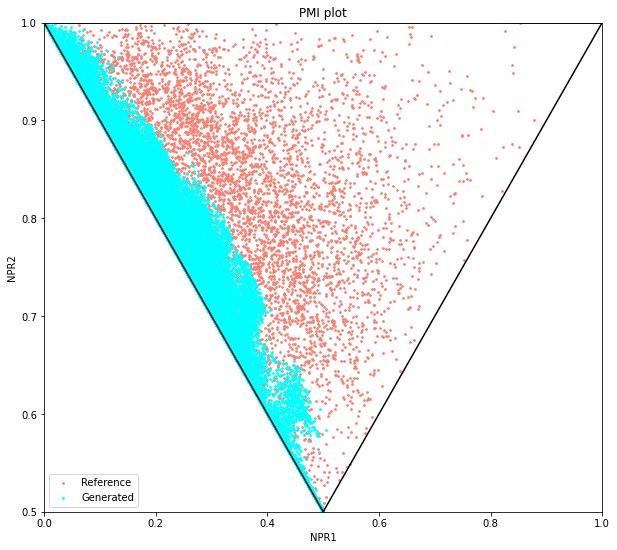

In [14]:
plt.figure(figsize=(10,9))
plt.scatter(npr1s_ref, npr2s_ref, c='salmon', label='Reference', s=3)
plt.scatter(npr1s_gen, npr2s_gen, c='cyan', label='Generated', s=3)
plt.axline((0,1),(0.5,0.5),c='black')
plt.axline((1,1),(0.5,0.5),c='black')
plt.axline((0,1),(1,1),c='black')
plt.xlim(0, 1)
plt.ylim(0.5, 1)
plt.xlabel('NPR1')
plt.ylabel('NPR2')
plt.title('PMI plot')
plt.legend()
plt.savefig('molecule_geometry_descriptors_qm9.png', dpi=300)

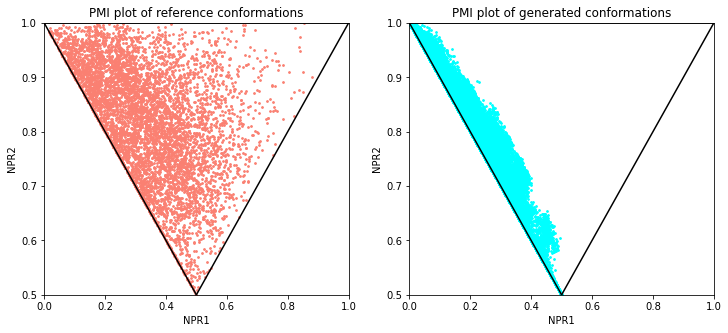

In [11]:
fig, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(12,5))

ax1.scatter(npr1s_ref, npr2s_ref, c='salmon', label='Reference', s=3)
ax1.axline((0,1),(0.5,0.5),c='black')
ax1.axline((1,1),(0.5,0.5),c='black')
ax1.axline((0,1),(1,1),c='black')
ax1.set_xlim(0, 1)
ax1.set_ylim(0.5, 1)
ax1.set_xlabel('NPR1')
ax1.set_ylabel('NPR2')
ax1.set_title('PMI plot of reference conformations')

ax2.scatter(npr1s_gen, npr2s_gen, c='cyan', label='Generated', s=3)
ax2.axline((0,1),(0.5,0.5),c='black')
ax2.axline((1,1),(0.5,0.5),c='black')
ax2.axline((0,1),(1,1),c='black')
ax2.set_xlim(0, 1)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('NPR1')
ax2.set_ylabel('NPR2')
ax2.set_title('PMI plot of generated conformations')
#plt.legend()
plt.savefig('molecule_geometry_descriptors_qm9.png', dpi=300)

In [13]:
print(np.array(asph_gen).mean())
print(np.array(asph_ref).mean())

0.49722123570667887
0.34756382342126635


In [11]:
batch = next(iter(data_module.test_dataloader()))

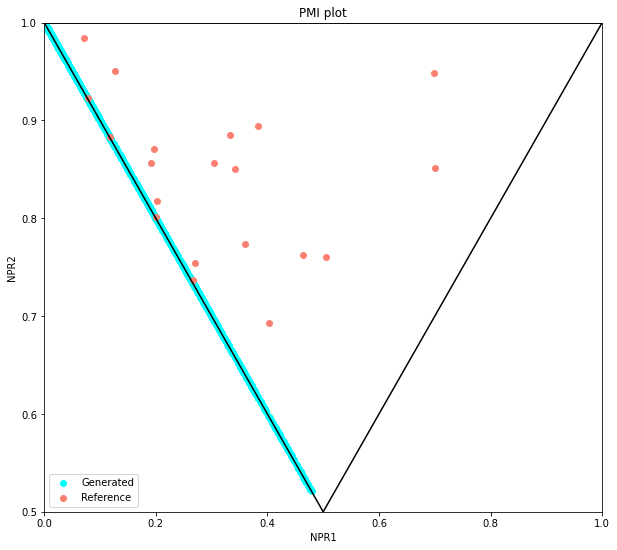

In [12]:
tensors, mols = batch
nodes, masks, edges, proximity, pos = tensors
n_confs=100
#masks = masks.unsqueeze(-1)

npr1s_gen = []
npr2s_gen = []
npr1s_ref = []
npr2s_ref = []
asph_gen = []
asph_ref = []
for mol_idx in range(len(mols)) :
    
    mol = mols[mol_idx]
    nodes_i = nodes[mol_idx]
    edges_i = edges[mol_idx]
    masks_i = masks[mol_idx]
    confs_mol = generate_conformations(mol, model, nodes_i, edges_i, masks_i, n_confs)
    for i in range(confs_mol.GetNumConformers()) :
        npr1s_gen.append(NPR1(confs_mol, i))
        npr2s_gen.append(NPR2(confs_mol, i))
        asph_gen.append(Asphericity(confs_mol, i))
    npr1s_ref.append(NPR1(mol, 0))    
    npr2s_ref.append(NPR2(mol, 0))
    asph_ref.append(Asphericity(mol, 0))
    
plt.figure(figsize=(10,9))
plt.scatter(npr1s_gen, npr2s_gen, c='cyan', label='Generated')
plt.scatter(npr1s_ref, npr2s_ref, c='salmon', label='Reference')
plt.axline((0,1),(0.5,0.5),c='black')
plt.axline((1,1),(0.5,0.5),c='black')
plt.axline((0,1),(1,1),c='black')
plt.xlim(0, 1)
plt.ylim(0.5, 1)
plt.xlabel('NPR1')
plt.ylabel('NPR2')
plt.title('PMI plot')
plt.legend()
plt.savefig('molecule_geometry_descriptors.png', dpi=300)

In [13]:
np.array(asph_gen).mean()

0.6318668965485852

In [14]:
np.array(asph_ref).mean()

0.39920056358515515

In [ ]:
def explore_latent_space(nodes, masks, edges, mols) :
    """
    nodes, masks, edges and mols are repeated lists/tensors by n_conf
    """
    X_pred = model.latent_space_interpolation(nodes, masks, edges)
    rmsds_raw = []
    rmsds_opti = []
    generated_confs_mol = copy.deepcopy(mols[0])
    generated_confs_mol.RemoveConformer(0)
    for mol_idx, (ref_mol, gen_pos) in enumerate(zip(mols, X_pred)) :
        i = batch_idx * len(mols) + mol_idx

        rmsd_raw, rmsd_opti, test_mol, test_mol_optimized = getRMSD(ref_mol, gen_pos)
        rmsds_raw.append(rmsd_raw)
        if rmsd_opti is not None :
            rmsds_opti.append(rmsd_opti)

        etkdg_conf, mmff_conf = generateETKDGConf(ref_mol)

        final_mol = copy.deepcopy(ref_mol)
        for mol in [test_mol, test_mol_optimized, etkdg_conf, mmff_conf] :
            if mol != None :
                final_mol.AddConformer(mol.GetConformer(0), assignId=True)

        generated_confs_mol.AddConformer(test_mol.GetConformer(0), assignId=True)

        Chem.rdMolAlign.AlignMolConformers(final_mol)

    #     w = Chem.SDWriter(f"{gen_dir}{i}.sdf")
    #     for conf_id in range(len(final_mol.GetConformers())) :
    #         w.write(final_mol, confId=conf_id)
    #     w.close()

        AllChem.Compute2DCoords(final_mol)
        Draw.MolToFile(final_mol, f"{gen_dir}{i}.png") 

    w = Chem.SDWriter(f"{gen_dir}latent_space_exploration.sdf")
    for conf_id in range(len(generated_confs_mol.GetConformers())) :
        w.write(generated_confs_mol, confId=conf_id)
    w.close()

In [52]:
def optimizeWithFF(mol):

    opti_mol = copy.deepcopy(mol)
    opti_mol = Chem.AddHs(opti_mol, addCoords=True)
#     print(len(opti_mol.GetConformers()))
    AllChem.MMFFOptimizeMolecule(opti_mol)
    opti_mol = Chem.RemoveHs(opti_mol)

    return opti_mol

def generateETKDGConf(mol) :
    
    original_mol = copy.deepcopy(mol) # copy to avoid modifying the input mol object
    original_mol.RemoveConformer(0)
    original_mol = Chem.AddHs(original_mol)
    
    try : # EmbedMolecule might not find a conformation
        AllChem.EmbedMolecule(original_mol)
        opti_mol = copy.deepcopy(original_mol)
        
        original_mol = Chem.RemoveHs(original_mol)
        
        AllChem.MMFFOptimizeMolecule(opti_mol)
        opti_mol = Chem.RemoveHs(opti_mol)
    except :
        original_mol = None
        opti_mol = None

    return original_mol, opti_mol

def getRMSD(reference_mol, positions):
    """
    Args :
        reference_mol : RDKit.Molecule
        positions : Tensor(n_atom, 3)
    """

    n_atom = reference_mol.GetNumAtoms()

    test_cf = Chem.rdchem.Conformer(n_atom)
    for k in range(n_atom):
        test_cf.SetAtomPosition(k, positions[k].tolist())

    test_mol = copy.deepcopy(reference_mol)
    test_mol.RemoveConformer(0)
    test_mol.AddConformer(test_cf)

    try :
        test_mol_optimized = optimizeWithFF(test_mol)
        rmsd_opti = AllChem.AlignMol(reference_mol, test_mol_optimized)
    except :
        test_mol_optimized = None
        rmsd_opti = None
        
    rmsd_raw = AllChem.AlignMol(reference_mol, test_mol)
        
    return rmsd_raw, rmsd_opti, test_mol, test_mol_optimized

In [53]:
def generate_conformations(batch_idx, batch, gen_dir) :
    print(batch_idx)
    tensors, mols = batch
    nodes, masks, edges, proximity, pos = tensors
    #masks = masks.unsqueeze(-1)
    
    postZ_mu, postZ_lsgms, priorZ_mu, priorZ_lsgms, X_pred, PX_pred = model(nodes, masks, edges, proximity, pos)
    
    rmsds_raw = []
    rmsds_opti = []
    for mol_idx, (ref_mol, gen_pos) in enumerate(zip(mols, PX_pred)) :
        i = batch_idx * len(mols) + mol_idx
#         print(i)
        
        rmsd_raw, rmsd_opti, test_mol, test_mol_optimized = getRMSD(ref_mol, gen_pos)
        rmsds_raw.append(rmsd_raw)
        if rmsd_opti is not None :
            rmsds_opti.append(rmsd_opti)
        w = Chem.SDWriter(f"{gen_dir}{i}.sdf")
        
        etkdg_conf, mmff_conf = generateETKDGConf(ref_mol)
        
        final_mol = copy.deepcopy(ref_mol)
        for mol in [test_mol, test_mol_optimized, etkdg_conf, mmff_conf] :
            if mol != None :
                final_mol.AddConformer(mol.GetConformer(0), assignId=True)
            
        Chem.rdMolAlign.AlignMolConformers(final_mol)
            
        for conf_id in range(len(final_mol.GetConformers())) :
            w.write(final_mol, confId=conf_id)
        
        w.close()
        
        AllChem.Compute2DCoords(final_mol)
        Draw.MolToFile(final_mol, f"{gen_dir}{i}.png") 

    rmsds_raw = np.array(rmsds_raw)
    rmsds_opti = np.array(rmsds_opti)
#     print(f"Mean RMSD raw = {rmsds_raw.mean()}")
#     print(f"Median RMSD raw = {np.median(rmsds_raw)}")
#     print(f"Mean RMSD opti = {rmsds_opti.mean()}")
#     print(f"Median RMSD opti = {np.median(rmsds_opti)}")

In [54]:
postZ_mu, postZ_lsgms, priorZ_mu, priorZ_lsgms, X_pred, PX_pred = model(nodes, masks, edges, proximity, pos)
    
rmsds_raw = []
rmsds_opti = []
generated_confs_mol = copy.deepcopy(mols[0])
generated_confs_mol.RemoveConformer(0)
for mol_idx, (ref_mol, gen_pos) in enumerate(zip(mols, PX_pred)) :
    i = batch_idx * len(mols) + mol_idx

    rmsd_raw, rmsd_opti, test_mol, test_mol_optimized = getRMSD(ref_mol, gen_pos)
    rmsds_raw.append(rmsd_raw)
    if rmsd_opti is not None :
        rmsds_opti.append(rmsd_opti)
    w = Chem.SDWriter(f"{gen_dir}{i}.sdf")

    etkdg_conf, mmff_conf = generateETKDGConf(ref_mol)

    final_mol = copy.deepcopy(ref_mol)
    for mol in [test_mol, test_mol_optimized, etkdg_conf, mmff_conf] :
        if mol != None :
            final_mol.AddConformer(mol.GetConformer(0), assignId=True)

    generated_confs_mol.AddConformer(test_mol.GetConformer(0), assignId=True)
            
    Chem.rdMolAlign.AlignMolConformers(final_mol)

    for conf_id in range(len(final_mol.GetConformers())) :
        w.write(final_mol, confId=conf_id)

    w.close()

    AllChem.Compute2DCoords(final_mol)
    Draw.MolToFile(final_mol, f"{gen_dir}{i}.png") 
    
w = Chem.SDWriter(f"{gen_dir}all_generated_confs.sdf")
for conf_id in range(len(generated_confs_mol.GetConformers())) :
    w.write(generated_confs_mol, confId=conf_id)
w.close()

In [55]:
cs = ConfScorer()

In [56]:
cs.get_interconformer_mean_rmsd(generated_confs_mol)

0.38691223382391576

In [54]:
gen_dir = 'generation_sdf_qm9/'
Path(gen_dir).mkdir(exist_ok=True)
for batch_idx, batch in enumerate(data_module.test_dataloader()) :
    generate_conformations(batch_idx, batch, gen_dir)

0
1
2
3


RuntimeError: DataLoader worker (pid(s) 19532) exited unexpectedly